In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict
import tabulate
import time
import GPy
from IPython.display import display

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Monthly transaction data

In [4]:
transaction_data = pandas.read_csv('data/transactions/anonymized.csv')
transaction_data['day'] = [d[:2] for d in transaction_data.Date]
transaction_data['month_year'] = [d[2:] for d in transaction_data.Date]
transaction_data.head()

,Date,Amount,day,month_year
0,25May2016,54241.35,25,May2016
1,29May2017,54008.83,29,May2017
2,30Jun2017,54008.82,30,Jun2017
3,05Jan2017,52704.37,05,Jan2017
4,23Feb2017,52704.36,23,Feb2017


In [5]:
counts_by_month = transaction_data.groupby('month_year').count()

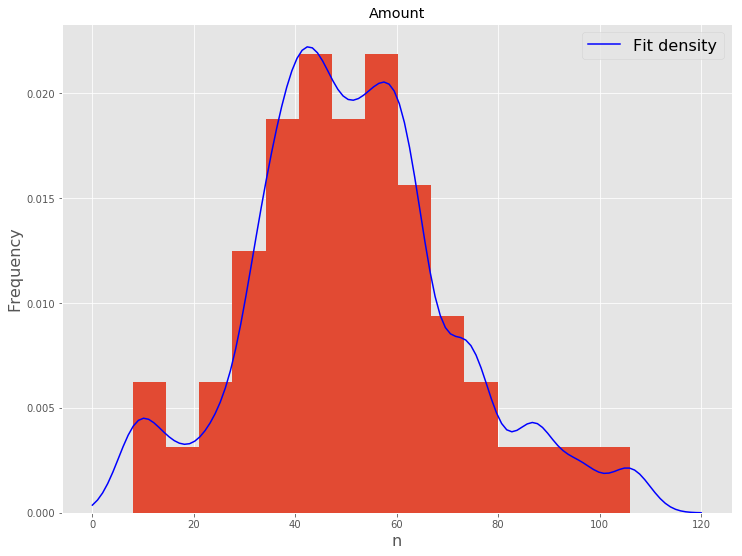

In [24]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=4).fit(counts_by_month.Amount.as_matrix().reshape((-1, 1)))

x_range = np.linspace(0, 120, 120).reshape((-1, 1))
y_density = np.exp(kde.score_samples(x_range))

axes = counts_by_month.hist('Amount', bins=15, normed=True, figsize=(12, 9))[0][0]
axes.plot(x_range, y_density, color='blue', label='Fit density')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'Frequency', size=16)
plt.show()

In [25]:
kde.sample(10)

array([[  36.5942288 ],
       [  92.22840408],
       [ 108.72042118],
       [  47.97446663],
       [  44.93418069],
       [  31.42128393],
       [  33.93127231],
       [  11.56626245],
       [  41.55396948],
       [  44.40623082]])

## Survey Data

In [8]:
p_cluster = [0.4, 0.3, 0.15, 0.15]

n_questions = 20
n_people = 1000
n_clusters = len(p_cluster)

biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))
people = np.random.choice(range(n_clusters), size=n_people, p=p_cluster)

answers = np.zeros((n_people, n_questions), dtype=bool)

for a in range(n_people):
    cluster = people[a]
    answers[a, :] = np.random.rand(n_questions) < biases[:, cluster]

print(people)

np.savetxt("data/questionnaire/questionnaire.csv", answers, delimiter=",", fmt="%d")
np.savetxt("data/questionnaire/questionnaire_answers.csv", people, delimiter=",", fmt="%d")
np.savetxt("data/questionnaire/questionnaire_biases.csv", biases, delimiter=",", fmt="%.3f")

[0 2 0 0 2 1 0 3 2 3 3 0 3 0 0 0 0 1 1 2 1 0 0 0 1 0 1 0 0 1 2 3 0 2 0 0 2
 1 2 3 0 0 2 0 0 0 3 1 0 1 3 0 3 0 1 2 1 1 1 1 2 0 0 0 3 1 1 1 1 2 2 0 1 2
 0 0 1 0 2 1 0 1 3 0 0 0 2 1 0 1 1 0 1 3 1 0 0 0 2 0 0 3 2 3 0 1 0 3 2 0 0
 0 1 3 0 1 1 0 3 2 3 1 2 3 1 0 2 1 2 0 2 2 1 1 0 1 1 2 1 3 1 0 0 0 1 3 1 1
 0 2 1 0 2 1 3 1 2 2 0 0 0 3 1 0 0 0 3 1 2 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0
 3 0 1 3 2 0 0 1 0 0 0 1 1 0 0 1 3 1 0 2 0 1 2 3 1 1 2 2 1 1 0 1 0 1 0 3 1
 1 1 2 3 0 0 2 1 1 0 1 1 1 3 2 3 0 0 1 0 2 1 1 3 0 0 3 0 2 0 0 2 2 0 0 0 0
 0 0 1 0 3 2 0 1 3 0 3 1 1 2 1 1 3 1 0 1 0 1 2 1 0 1 0 0 1 0 0 1 0 2 2 2 3
 1 1 3 0 3 0 0 1 0 1 0 0 1 0 0 2 0 0 2 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 0 3 3 1 1 0 0 0 0 3 0 1 2 1 0 3 1 0 1 1 1 3 0 2 0 0 2 0 0 1 0 0 3 3 2 0 1
 3 1 0 1 2 2 2 1 0 3 1 0 0 1 1 3 1 0 1 0 0 1 3 1 0 1 2 3 0 0 2 3 0 0 1 3 0
 2 1 0 1 2 2 0 1 0 3 2 0 0 0 3 2 0 0 2 0 2 1 2 0 1 1 1 0 0 0 0 3 3 3 0 1 1
 3 1 0 1 1 1 3 2 1 0 1 1 0 0 1 0 1 1 1 0 1 0 3 2 0 2 3 0 3 0 1 3 1 1 0 3 1
 1 0 1 1 0 0 1 2 0 1 3 0 

Let's translate this question into Barber's notation.

We have $H=4$ clusters, and $D=20$ dimensions in the data.

`p_clusters` is p(h), the probability of placing a person a prior in each cluster.

The observed data **v** is `answers`, a binary vector for each person. This hints we should model it as a mixture of products of Bernoulli distributions. $V$ is a $N \times D$ matrix, where $v_{ni} = v_i^n$ represents the nth person's answer to the ith question.

`biases` is p(**v** | h), the mapping between a cluster and the answer probabilities in it. We can represent `biases` as a $D \times H$ matrix $B$, where $B_{ij} = p(v_i = 1 | h = j)$

`people` represents p(h | **v**), the probability that each particular person is assigned to a given cluster, given their answers. $P$ is an $N \times H$ matrix, where $P_{nj} = P(h=j | \mathbf{v^n})$ 

In [9]:
n_people, n_questions

(1000, 20)

In [17]:
import numpy as np

answers = np.loadtxt("data/questionnaire/questionnaire.csv", delimiter=",")
n_people, n_questions = answers.shape
n_clusters = 4

p_clusters = np.asarray([0.25, 0.25, 0.25, 0.25])
biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))


def expectation(answers, biases, p_clusters):
    # In this function we create our expectations.
    p_h_given_v = np.zeros((n_people, n_clusters))
    for n in range(n_people):
        for j in range(n_clusters):
            p_h_given_v[n, j] = p_clusters[j] * np.prod(np.multiply(answers[n], biases[:,j]) + \
                                                       np.multiply(1 - answers[n], 1 - biases[:,j]))
    
    # normalize the distributions
    p_h_given_v /= p_h_given_v.sum(axis=1, keepdims=1)
    return p_h_given_v


def maximization(answers, people):
    # Treating all the data as visible, now infer the parameters for the model.
    # p_clusters is p(h)
    p_h = np.sum(people, axis=0)
    p_h /= np.sum(p_h)

    p_v_given_h = np.matmul(answers.T, people)
    p_v_given_h = np.divide(p_v_given_h, p_v_given_h + np.matmul(1 - answers.T, people))
    
    return p_h, p_v_given_h


for step in range(100):
    if 0 == step % 10: print(step)
    people = expectation(answers, biases, p_clusters)
    p_clusters, biases = maximization(answers, people)

print(biases)
print(people)

0
10
20
30
40
50
60
70
80
90
[[  1.05810490e-01   3.41734734e-01   2.98700382e-01   5.10278048e-01]
 [  5.30053345e-01   7.39249110e-01   7.96654536e-01   7.19287882e-01]
 [  5.84209298e-01   3.47685641e-01   2.89058611e-01   9.78639358e-02]
 [  2.09955374e-01   3.02832237e-01   4.80497577e-01   1.00000000e+00]
 [  3.76872627e-01   1.88382431e-03   3.86952981e-01   7.58247373e-01]
 [  1.37699029e-01   7.91653754e-01   2.57608426e-01   4.37608248e-01]
 [  3.21134139e-01   5.64877940e-01   5.79967634e-01   1.26551239e-01]
 [  6.74436805e-01   4.05077174e-12   2.30716971e-02   6.68097132e-01]
 [  3.07968300e-01   3.61042280e-03   1.63524216e-01   9.07305397e-01]
 [  2.21686857e-01   9.86439422e-01   9.62168564e-01   6.13504360e-01]
 [  1.40736137e-01   3.82875615e-01   3.19045612e-01   1.94590154e-01]
 [  4.14145439e-01   7.72304999e-01   8.02698385e-01   9.85185818e-01]
 [  2.98975619e-01   7.83132981e-02   1.23635222e-01   6.36165195e-01]
 [  8.65404870e-01   3.02232182e-01   2.64860098

In [14]:
orig_biases = np.loadtxt("data/questionnaire/questionnaire_biases.csv", delimiter=",")

In [18]:
biases - orig_biases

array([[-0.18618951, -0.15626527,  0.23970038,  0.43327805],
       [-0.23994665, -0.01775089, -0.18734546,  0.55728788],
       [ 0.2492093 ,  0.25468564, -0.21694139, -0.58713606],
       [-0.22604463, -0.69616776, -0.04650242,  0.996     ],
       [ 0.02087263, -0.75711618,  0.01195298,  0.49924737],
       [-0.19030097,  0.35765375, -0.01139157,  0.43160825],
       [-0.23586586,  0.42487794, -0.14403237,  0.11555124],
       [ 0.6634368 , -0.655     , -0.4989283 , -0.13490287],
       [ 0.1589683 , -0.91438958, -0.27147578,  0.6123054 ],
       [-0.75731314,  0.32843942,  0.70316856,  0.46950436],
       [-0.17026386,  0.16387562,  0.31504561, -0.07640985],
       [-0.36485456, -0.198695  ,  0.47169839,  0.40818582],
       [ 0.15897562, -0.5196867 , -0.46136478,  0.5291652 ],
       [ 0.56140487, -0.69276782, -0.6161399 ,  0.14311639],
       [ 0.28131267, -0.10197584, -0.4741863 ,  0.00265079],
       [-0.06310092,  0.47197505,  0.45918294, -0.8147673 ],
       [-0.53412583, -0.

In [ ]:
#pjs version - now make sure you can explain the answer.

import numpy as np

answers = np.loadtxt("questionnaire.csv", delimiter=",")
n_people, n_questions = answers.shape
n_clusters = 4

p_clusters = np.asarray([0.25, 0.25, 0.25, 0.25])
biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))


def expectation(answers, biases, p_clusters):
    # In this function we create our expectations.
    #
    # people = np.random.rand(n_people, n_clusters)
    # people = people / people.sum(axis=1,
    #                              keepdims=1)  # normalize the distributions

    log_bias = np.log(biases)
    log_other_bias = np.log1p(-biases)
    people = np.zeros((n_people, n_clusters))

    for a in range(n_clusters):
        term1 = (answers.T * log_bias[:, a:a + 1]).sum(0)
        term2 = ((1 - answers).T * log_other_bias[:, a:a + 1]).sum(0)
        people[:, a] = np.log(p_clusters[a]) + term1 + term2

    people = people - people.max()
    people = np.exp(people)
    # normalize the distributions
    people = people / people.sum(axis=1, keepdims=1)
    return people


def maximization(answers, people):
    # Treating all the data as visible, now infer the parameters for the model.
    biases = np.zeros((n_questions, n_clusters))
    for a in range(n_clusters):
        temp = people[:, a:a + 1]
        z = temp.sum()
        biases[:, a] = (temp * answers).sum(0) / z
    return biases


for step in range(10):
    people = expectation(answers, biases, p_clusters)
    biases = maximization(answers, people)
    print(biases)
    # print(people)